# Creating Spark Session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

24/04/06 18:25:57 WARN Utils: Your hostname, Gauravs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.104 instead (on interface en0)
24/04/06 18:25:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/06 18:25:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Access Spark UI
spark

# Note
These questions are taken from <a href="https://www.linkedin.com/groups/14422071/">PySpark Coding Question (Linkedln Group)</a>

# Q1 :  
```
Find the trending  s
If a   appears more than once in a single comment, still the   occurrence will be considered as 1.

data = [
 ("Great day! 😊  #happy  #sunny  #workout",),
 ("Enjoying the weekend!  #fun  #fun  #funny  #friends",),
 ("Coding all day.  #work  #code  #productive  #code  #work",),
 ("Another day at the office.  #work  #busy",),
 (" #happy  #sunny  #workout  #happy",),
 ("Late-night coding session.  #code  #productive  #code  #tired",),
 ("Fun time with friends.  #fun  #friends  #happy  #fun",),
 (" #happy  #coding 😊  #productive  #happy",),
 (" #funny  #funny  #funny  #humor",),
 ("Working on a project.  #work  #project  #productive",),
]

Have a more optimized solution? Please comment.
Scope of improvement - avoid UDF , Handle corner case such as case sensitivity etc
```

In [3]:
from pyspark.sql.types import StringType,StructField,StructType

data = [
 ("Great day! 😊  #happy  #sunny  #workout",),
 ("Enjoying the weekend!  #fun  #fun  #funny  #friends",),
 ("Coding all day.  #work  #code  #productive  #code  #work",),
 ("Another day at the office.  #work  #busy",),
 (" #happy  #sunny  #workout  #happy",),
 ("Late-night coding session.  #code  #productive  #code  #tired",),
 ("Fun time with friends.  #fun  #friends  #happy  #fun",),
 (" #happy  #coding 😊  #productive  #happy",),
 (" #funny  #funny  #funny  #humor",),
 ("Working on a project.  #work  #project  #productive",),
]

schema = StructType([
    StructField('post',StringType(),True)
])

df = spark.createDataFrame(data,schema=schema)
df.show()

+--------------------+
|                post|
+--------------------+
|Great day! 😊  #h...|
|Enjoying the week...|
|Coding all day.  ...|
|Another day at th...|
| #happy  #sunny  ...|
|Late-night coding...|
|Fun time with fri...|
| #happy  #coding ...|
| #funny  #funny  ...|
|Working on a proj...|
+--------------------+



In [4]:
from pyspark.sql.functions import split,col
split_data = df.select(split(col('post'),' ').alias('split'))
split_data.show()

+--------------------+
|               split|
+--------------------+
|[Great, day!, 😊,...|
|[Enjoying, the, w...|
|[Coding, all, day...|
|[Another, day, at...|
|[, #happy, , #sun...|
|[Late-night, codi...|
|[Fun, time, with,...|
|[, #happy, , #cod...|
|[, #funny, , #fun...|
|[Working, on, a, ...|
+--------------------+



In [5]:
# you can also make use of array_distinct in spark dataframe if you dont want to use set in udf
def get_only_hashtags_unique(arr):
    li = set()
    for x in arr:
        if x.strip().startswith('#'):
            li.add(x.strip())
    return list(li)

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType,StringType

unique_only_hashtag = udf(get_only_hashtags_unique,ArrayType(StringType()))

unique_hashtags = split_data.select(unique_only_hashtag(col('split')).alias('only_hashtag'))
unique_hashtags.show()

+--------------------+
|        only_hashtag|
+--------------------+
|[#sunny, #workout...|
|[#fun, #funny, #f...|
|[#code, #work, #p...|
|      [#busy, #work]|
|[#sunny, #workout...|
|[#code, #producti...|
|[#fun, #friends, ...|
|[#coding, #produc...|
|    [#funny, #humor]|
|[#work, #project,...|
+--------------------+



In [7]:
from pyspark.sql.functions import explode

explode_data = unique_hashtags.select(explode(col('only_hashtag')).alias('explode'))
explode_data.show()

+-----------+
|    explode|
+-----------+
|     #sunny|
|   #workout|
|     #happy|
|       #fun|
|     #funny|
|   #friends|
|      #code|
|      #work|
|#productive|
|      #busy|
|      #work|
|     #sunny|
|   #workout|
|     #happy|
|      #code|
|#productive|
|     #tired|
|       #fun|
|   #friends|
|     #happy|
+-----------+
only showing top 20 rows



In [8]:
get_count = explode_data.groupBy(col('explode')).count()
get_count.show()

+-----------+-----+
|    explode|count|
+-----------+-----+
|     #happy|    4|
|     #sunny|    2|
|   #workout|    2|
|       #fun|    2|
|   #friends|    2|
|     #funny|    2|
|#productive|    4|
|      #code|    2|
|      #work|    3|
|      #busy|    1|
|     #tired|    1|
|    #coding|    1|
|   #project|    1|
|     #humor|    1|
+-----------+-----+



In [9]:
# from pyspark.sql.functions import sort
get_count.select('*').orderBy(col('count').desc()).show()

+-----------+-----+
|    explode|count|
+-----------+-----+
|     #happy|    4|
|#productive|    4|
|      #work|    3|
|     #sunny|    2|
|   #workout|    2|
|       #fun|    2|
|   #friends|    2|
|     #funny|    2|
|      #code|    2|
|      #busy|    1|
|     #tired|    1|
|    #coding|    1|
|   #project|    1|
|     #humor|    1|
+-----------+-----+



In [10]:
# Final Code
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql.types import StringType,StructField,StructType
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType,StringType
from pyspark.sql.functions import split,col
from pyspark.sql.functions import explode


# UDF
def get_only_hashtags_unique(arr):
    li = set()
    for x in arr:
        if x.strip().startswith('#'):
            li.add(x.strip())
    return list(li)
#Register UDF
unique_only_hashtag = udf(get_only_hashtags_unique,ArrayType(StringType()))


# Stage 1
data = [
 ("Great day! 😊  #happy  #sunny  #workout",),
 ("Enjoying the weekend!  #fun  #fun  #funny  #friends",),
 ("Coding all day.  #work  #code  #productive  #code  #work",),
 ("Another day at the office.  #work  #busy",),
 (" #happy  #sunny  #workout  #happy",),
 ("Late-night coding session.  #code  #productive  #code  #tired",),
 ("Fun time with friends.  #fun  #friends  #happy  #fun",),
 (" #happy  #coding 😊  #productive  #happy",),
 (" #funny  #funny  #funny  #humor",),
 ("Working on a project.  #work  #project  #productive",),
]

schema = StructType([
    StructField('post',StringType(),True)
])

df = spark.createDataFrame(data,schema=schema)
split_data = df.select(split(col('post'),' ').alias('split'))
unique_hashtags = split_data.select(unique_only_hashtag(col('split')).alias('only_hashtag'))
explode_data = unique_hashtags.select(explode(col('only_hashtag')).alias('explode'))


# Stage 2
get_count = explode_data.groupBy(col('explode')).count()
# from pyspark.sql.functions import sort
get_count.select('*').orderBy(col('count').desc()).show()

+-----------+-----+
|    explode|count|
+-----------+-----+
|     #happy|    4|
|#productive|    4|
|      #work|    3|
|     #sunny|    2|
|   #workout|    2|
|       #fun|    2|
|   #friends|    2|
|     #funny|    2|
|      #code|    2|
|      #busy|    1|
|     #tired|    1|
|    #coding|    1|
|   #project|    1|
|     #humor|    1|
+-----------+-----+



In [11]:
df.rdd.getNumPartitions()

8

In [12]:
get_count.rdd.getNumPartitions()

1

# Q2

##### Task - Write a Spark code snippet to group data on multiples of 100 and get max number from that group.

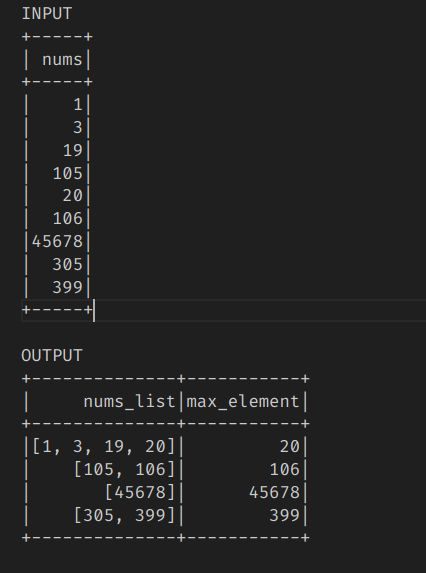

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import *

# Create a SparkSession
spark = SparkSession.builder \
 .appName("CreateDataFrameExample") \
 .getOrCreate()
spark

24/04/06 17:53:56 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [14]:
# Define the schema for the DataFrame
schema = StructType([
 StructField("nums", IntegerType(), True),
])

# Sample numbers data
data = [(1,),(3,),(19,),(105,),(20,),(106,),(45678,),(305,),(399,)]

# Create a DataFrame from the sample data and schema
nums_df = spark.createDataFrame(data, schema)

# Show the DataFrame
nums_df.show()

+-----+
| nums|
+-----+
|    1|
|    3|
|   19|
|  105|
|   20|
|  106|
|45678|
|  305|
|  399|
+-----+



In [15]:
from pyspark.sql.functions import ceil
bucket = nums_df.select(col('*'),ceil((col('nums')/100)).alias('bucket'))
bucket.show()

+-----+------+
| nums|bucket|
+-----+------+
|    1|     1|
|    3|     1|
|   19|     1|
|  105|     2|
|   20|     1|
|  106|     2|
|45678|   457|
|  305|     4|
|  399|     4|
+-----+------+



In [16]:
from pyspark.sql.functions import collect_list
bucket.groupBy('bucket').agg(collect_list('nums').alias('bucket_data'),\
                            max('nums').alias('max_in_bucket'))\
                            .select('bucket_data','max_in_bucket').show()

+--------------+-------------+
|   bucket_data|max_in_bucket|
+--------------+-------------+
|[1, 3, 19, 20]|           20|
|    [105, 106]|          106|
|       [45678]|        45678|
|    [305, 399]|          399|
+--------------+-------------+



# Q3 : Mask the digits of a 16-digit credit card number

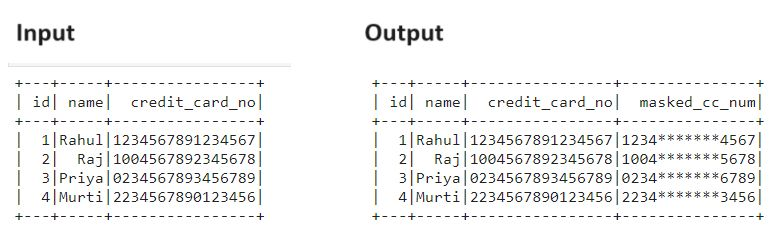

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat, lit, expr

# Create a Spark session
spark = SparkSession.builder.appName("MaskCreditCard").getOrCreate()

# Define the data
data = [
 (1, "Rahul", "1234567891234567"),
 (2, "Raj", "1004567892345678"),
 (3, "Priya", "0234567893456789"),
 (4, "Murti", "2234567890123456")
]

# Define the schema
schema = ["ID", "Name", "CreditCard"]

# Create a DataFrame
df = spark.createDataFrame(data, schema)

# Mask the credit card number
masked_df = df.withColumn("MaskedCreditCard", 
 concat(
 df.CreditCard.substr(1, 4), # First 4 digits
 lit("********"), # 8 asterisks
 df.CreditCard.substr(13, 4) # Last 4 digits
 ))

# Show the original and masked credit card numbers
masked_df.select("ID", "Name", "CreditCard", "MaskedCreditCard").show()

24/04/06 17:53:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+---+-----+----------------+----------------+
| ID| Name|      CreditCard|MaskedCreditCard|
+---+-----+----------------+----------------+
|  1|Rahul|1234567891234567|1234********4567|
|  2|  Raj|1004567892345678|1004********5678|
|  3|Priya|0234567893456789|0234********6789|
|  4|Murti|2234567890123456|2234********3456|
+---+-----+----------------+----------------+



# Q4 :  Write a Spark code snippet to delete column whose all values are null.

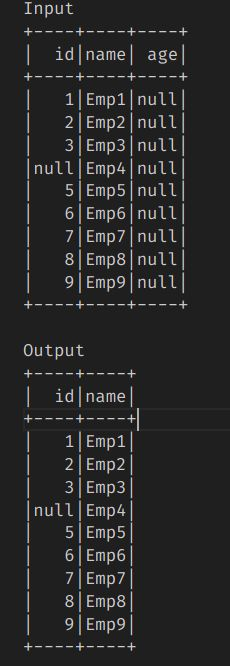

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, IntegerType, StringType
from pyspark.sql.functions import *

# Create a SparkSession
spark = SparkSession.builder \
 .appName("CreateDataFrameExample") \
 .getOrCreate()

# Define the schema for the DataFrame
schema = StructType([
 StructField("id", IntegerType(), True),
 StructField("name", StringType(), True),
 StructField("age", IntegerType(), True),
])

# Sample numbers data
data = [(1,"Emp1", None),(2, "Emp2", None),(3, "Emp3", None),(None, "Emp4", None),(5, "Emp5", None),(6, "Emp6", None),(7, "Emp7", None),(8, "Emp8", None),(9, "Emp9", None)]

# Create a DataFrame from the sample data and schema
df = spark.createDataFrame(data, schema)
df.show()

24/04/06 18:15:45 WARN Utils: Your hostname, Gauravs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.104 instead (on interface en0)
24/04/06 18:15:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/06 18:15:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----+----+----+
|  id|name| age|
+----+----+----+
|   1|Emp1|NULL|
|   2|Emp2|NULL|
|   3|Emp3|NULL|
|NULL|Emp4|NULL|
|   5|Emp5|NULL|
|   6|Emp6|NULL|
|   7|Emp7|NULL|
|   8|Emp8|NULL|
|   9|Emp9|NULL|
+----+----+----+



In [4]:
# OR #df.filter(isnull(col('id'))).count()
co = [x for x in df.columns if df.select(x).dropna().count()!=0]
df.select(co).show()

+----+----+
|  id|name|
+----+----+
|   1|Emp1|
|   2|Emp2|
|   3|Emp3|
|NULL|Emp4|
|   5|Emp5|
|   6|Emp6|
|   7|Emp7|
|   8|Emp8|
|   9|Emp9|
+----+----+



# Q5 : Last Person to Board Bus

```
There is a queue of people waiting to board a bus. However, the bus has a weight limit of 1000 kilograms, so there may be some people who cannot board.
Write a solution to find the person_name of the last person that can fit on the bus without exceeding the weight limit. The test cases are generated such that the first person does not exceed the weight limit.

data = [
 (5, "Alice", 250, 1),
 (4, "Bob", 175, 5),
 (3, "Alex", 350, 2),
 (6, "John Cena", 400, 3),
 (1, "Winston", 500, 6),
 (2, "Marie", 200, 4)
]

schema = StructType([
 StructField("person_id", IntegerType(), True),
 StructField("person_name", StringType(), True),
 StructField("weight", IntegerType(), True),
 StructField("turn", IntegerType(), True)
])

last_person = spark.createDataFrame(data = data, schema = schema)

Required_Output:
+-------------+
| person_name |
+-------------+
| John Cena |
+-------------+
```

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StructType,StructField,IntegerType,StringType
from pyspark.sql.functions import sum

spark = SparkSession.builder.getOrCreate()

data = [
    (5, "Alice", 250, 1),
    (4, "Bob", 175, 5),
    (3, "Alex", 350, 2),
    (6, "John Cena", 400, 3),
    (1, "Winston", 500, 6),
    (2, "Marie", 200, 4)
]

bus_schema = StructType([
    StructField("person_id",IntegerType()),
    StructField("person_name",StringType()),
    StructField("person_weight",IntegerType()),
    StructField("person_turn",IntegerType())
])

bus_df = spark.createDataFrame(data,bus_schema)

bus_window = Window.orderBy("person_turn")\
                    .rowsBetween(Window.unboundedPreceding,0)

bus_df1 = bus_df.withColumn("weight_sum",sum("person_weight").over(bus_window))\
                .filter("weight_sum<=1000")\
                .select("person_name")\
                .orderBy("weight_sum",ascending=False)\
                .limit(1)

bus_df1.show()

24/04/06 18:31:13 WARN Utils: Your hostname, Gauravs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.104 instead (on interface en0)
24/04/06 18:31:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/06 18:31:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/06 18:31:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 18:31:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 18:31:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performa

+-----------+
|person_name|
+-----------+
|  John Cena|
+-----------+



In [6]:
bus_df1.rdd.getNumPartitions()

24/04/06 18:31:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 18:31:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 18:31:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 18:31:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/06 18:31:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


1

# Q5  : Write a solution to find the number of times each student attended each exam.

```
students_data = [
 (1, "Alice"),
 (2, "Bob"),
 (13, "John"),
 (6, "Alex")
]

# Sample data for Subjects table
subjects_data = [
 ("Math",),
 ("Physics",),
 ("Programming",)
]

# Sample data for Examinations table
examinations_data = [
 (1, "Math"),
 (1, "Physics"),
 (1, "Programming"),
 (2, "Programming"),
 (1, "Physics"),
 (1, "Math"),
 (13, "Math"),
 (13, "Programming"),
 (13, "Physics"),
 (2, "Math"),
 (1, "Math")
]



# Output
+------------+--------------+--------------+----------------+
| student_id | student_name | subject_name | attended_exams |
+------------+--------------+--------------+----------------+
| 1 | Alice | Math | 3 |
| 1 | Alice | Physics | 2 |
| 1 | Alice | Programming | 1 |
| 2 | Bob | Math | 1 |
| 2 | Bob | Physics | 0 |
| 2 | Bob | Programming | 1 |
| 6 | Alex | Math | 0 |
| 6 | Alex | Physics | 0 |
| 6 | Alex | Programming | 0 |
| 13 | John | Math | 1 |
| 13 | John | Physics | 1 |
| 13 | John | Programming | 1 |
+------------+--------------+--------------+----------------+

```

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Create a SparkSession
spark = SparkSession.builder \
    .appName("CreateDataframes") \
    .getOrCreate()

# Schema for Students table
students_schema = StructType([
    StructField("student_id", IntegerType(), True),
    StructField("student_name", StringType(), True)
])

# Schema for Subjects table
subjects_schema = StructType([
    StructField("subject_name", StringType(), True)
])

# Schema for Examinations table
examinations_schema = StructType([
    StructField("student_id", IntegerType(), True),
    StructField("subject_name", StringType(), True)
])

# Sample data for Students table
students_data = [
    (1, "Alice"),
    (2, "Bob"),
    (13, "John"),
    (6, "Alex")
]

# Sample data for Subjects table
subjects_data = [
    ("Math",),
    ("Physics",),
    ("Programming",)
]

# Sample data for Examinations table
examinations_data = [
    (1, "Math"),
    (1, "Physics"),
    (1, "Programming"),
    (2, "Programming"),
    (1, "Physics"),
    (1, "Math"),
    (13, "Math"),
    (13, "Programming"),
    (13, "Physics"),
    (2, "Math"),
    (1, "Math")
]

# Create DataFrames
students_df = spark.createDataFrame(students_data, schema=students_schema)
subjects_df = spark.createDataFrame(subjects_data, schema=subjects_schema)
examinations_df = spark.createDataFrame(examinations_data, schema=examinations_schema)

# Show the DataFrames
print("Students DataFrame:")
students_df.show()

print("Subjects DataFrame:")
subjects_df.show()

print("Examinations DataFrame:")
examinations_df.show()

24/04/06 18:43:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Students DataFrame:
+----------+------------+
|student_id|student_name|
+----------+------------+
|         1|       Alice|
|         2|         Bob|
|        13|        John|
|         6|        Alex|
+----------+------------+

Subjects DataFrame:
+------------+
|subject_name|
+------------+
|        Math|
|     Physics|
| Programming|
+------------+

Examinations DataFrame:
+----------+------------+
|student_id|subject_name|
+----------+------------+
|         1|        Math|
|         1|     Physics|
|         1| Programming|
|         2| Programming|
|         1|     Physics|
|         1|        Math|
|        13|        Math|
|        13| Programming|
|        13|     Physics|
|         2|        Math|
|         1|        Math|
+----------+------------+



In [3]:
from pyspark.sql.functions import *

# Join students and subjects
student_sub = students_df.crossJoin(subjects_df)

# Left join with examinations to count attended exams
final_df = student_sub.join(examinations_df,(student_sub['student_id'] == examinations_df['student_id']) & \
                            (student_sub['subject_name'] == examinations_df['subject_name']), "left")\
                            .groupBy(student_sub['student_id'], student_sub['student_name'], student_sub['subject_name'])\
                            .agg(count(examinations_df['subject_name']).alias('attended_exams'))\
                            .orderBy(student_sub['student_id'], student_sub['subject_name'])

final_df.show()

+----------+------------+------------+--------------+
|student_id|student_name|subject_name|attended_exams|
+----------+------------+------------+--------------+
|         1|       Alice|        Math|             3|
|         1|       Alice|     Physics|             2|
|         1|       Alice| Programming|             1|
|         2|         Bob|        Math|             1|
|         2|         Bob|     Physics|             0|
|         2|         Bob| Programming|             1|
|         6|        Alex|        Math|             0|
|         6|        Alex|     Physics|             0|
|         6|        Alex| Programming|             0|
|        13|        John|        Math|             1|
|        13|        John|     Physics|             1|
|        13|        John| Programming|             1|
+----------+------------+------------+--------------+

